In [24]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sys

plt.style.use("../matplotlib_style/standard_plot_style.mplstyle")

import qutip

save_figures = True
save_path    = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/Figs/Results/readout_strategies"

sys.path.append("../utils")


In [25]:
data = pd.read_csv("/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/kode/experiments/trace_data/trace_2k_10us_10ns_resolution.csv")
dt   = 10

Classification procedures for detecting decays

1. Use simple sum of the two signals and seperate them
2. Calculate a chi-2 value for the mean path of the two signals and compare them

In [26]:
data

,trajectory,initial_state,I,Q,t
0,0,0,0.088654,-0.083207,0
1,0,0,-0.016861,0.007177,10
2,0,0,0.008373,-0.075257,20
3,0,0,0.091618,0.108743,30
4,0,0,-0.070568,0.067275,40
...,...,...,...,...,...
1051995,1999,1,0.031231,0.047182,5210
1051996,1999,1,0.021475,0.065333,5220
1051997,1999,1,0.021907,0.037958,5230
1051998,1999,1,-0.025766,-0.142284,5240


In [27]:
t = data.t.unique()
initial_state = data.groupby("trajectory").initial_state.first().values

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

IQ_data = data.loc[:, ("I", "Q")].values.reshape(2000, -1, 2) # Reshape into trajectory, time, I/Q

# Seperate to test and train. 0.75 / 0.25 split 
from sklearn.model_selection import train_test_split
IQ_train, IQ_test, initial_state_train, initial_state_test = train_test_split(IQ_data, initial_state, test_size=0.50, random_state=42)

# No test set
IQ_train = IQ_data
initial_state_train = initial_state


def sum_model(data, target, interval = (0, np.inf)):
    """
    Sum the I and Q components of the data in a given interval
    Perform an LDA transformation and return the probabilities for classification
    """
    consider_interval = np.logical_and(t >= interval[0], t <= interval[1])
    summed_data = np.sum(data[:, consider_interval, :], axis = 1)

    lda_model = LDA().fit(summed_data, target)

    probability_of_excited = lda_model.predict_proba(summed_data)

    return probability_of_excited

probs = sum_model(IQ_train, initial_state_train)


# Calculate mf weights
def weights(data, target):
    target = initial_state_train

    data_0 = data[target == 0, ...]
    data_1 = data[target == 1, ...]

    weights = (data_0.mean(axis = 0) - data_1.mean(axis = 0)) / (data_0.std(axis = 0) ** 2 + data_1.std(axis = 0) ** 2)
    return weights

weights_for_mf = weights(IQ_train, initial_state_train)


def mf_model(data, target, interval = (0, np.inf), weights = weights_for_mf):
    """
    Calculate the mean of the I and Q components of the data in a given interval
    Perform an LDA transformation and return the probabilities for classification
    """

    data = np.einsum("ijk, jk -> ijk", data, weights)

    consider_interval = np.logical_and(t >= interval[0], t <= interval[1])
    mean_data = np.mean(data[:, consider_interval, :], axis = 1)

    lda_model = LDA().fit(mean_data, target)

    probability_of_excited = lda_model.predict_proba(mean_data)

    return probability_of_excited

In [29]:
weights_for_mf.shape

(526, 2)

In [30]:
np.einsum("ijk, jk -> ijk", IQ_train, weights_for_mf).shape

(2000, 526, 2)

0.882

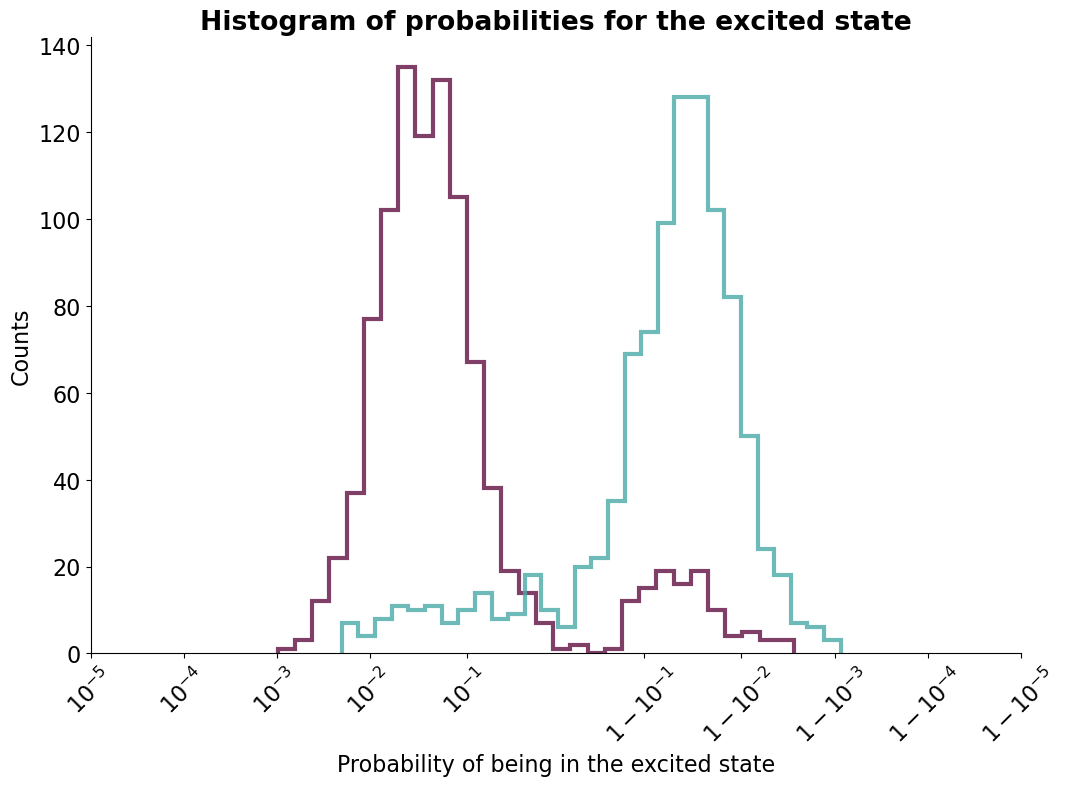

In [31]:
from scipy.special import logit
fig, ax = plt.subplots(1, 1)

probs = mf_model(IQ_train, initial_state_train, interval = (0, 2000))

ax.hist(logit(probs[initial_state_train == 0, 1]), bins = 30, alpha = 0.8, label = "Ground state", histtype = "step", linewidth = 3);
ax.hist(logit(probs[initial_state_train == 1, 1]), bins = 30, alpha = 0.8, label = "Excited state", histtype = "step", linewidth = 3);

label_pos = np.concatenate([logit(10. ** np.arange(-5, 0)), logit(1 - 10. ** np.arange(-5, 0))])
labels_left =  [f"$10^{{{number}}}$" for number in np.arange(-5, 0)]
labels_right = [f"$1 - 10^{{{number}}}$" for number in np.arange(-5, 0)]

ax.set_xticks(label_pos)
ax.set_xticklabels(labels_left + labels_right, rotation = 45)

ax.set(
    xlabel = "Probability of being in the excited state",
    ylabel = "Counts",
    title  = "Histogram of probabilities for the excited state"
)

from sklearn.metrics import accuracy_score

accuracy_score(initial_state_train, probs[:, 1] > 0.5)

(0.8735, 0.7480916030534351, 0.9041692594897324)

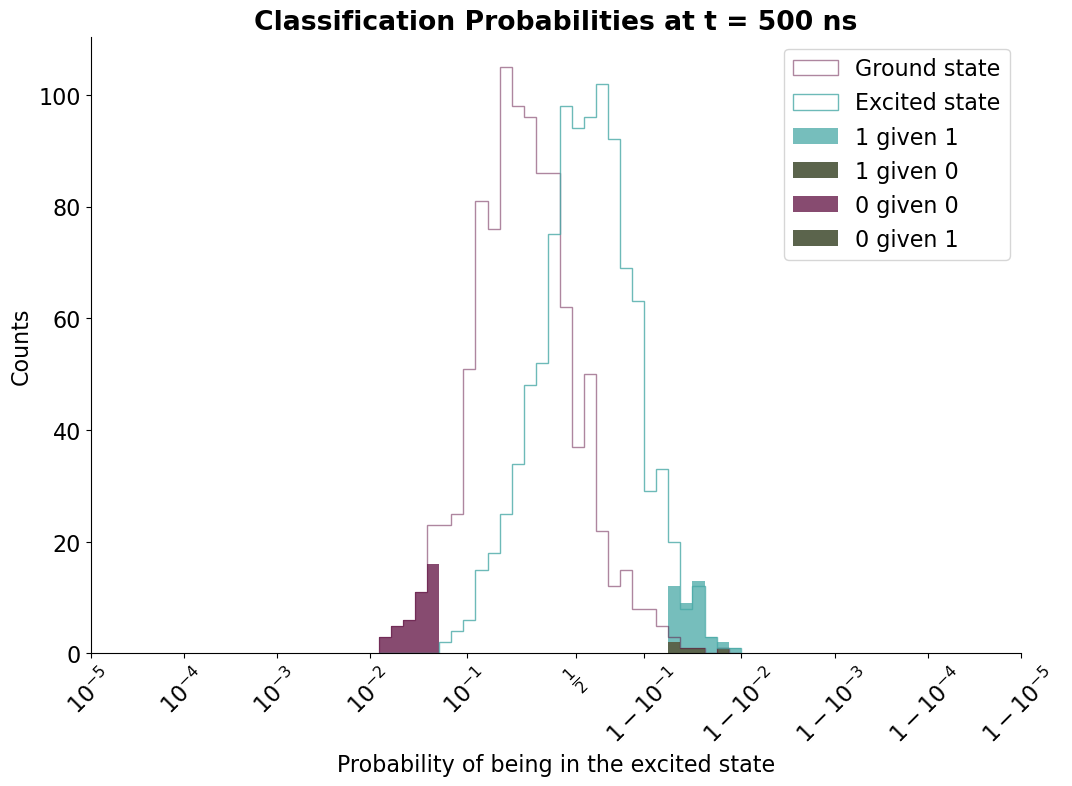

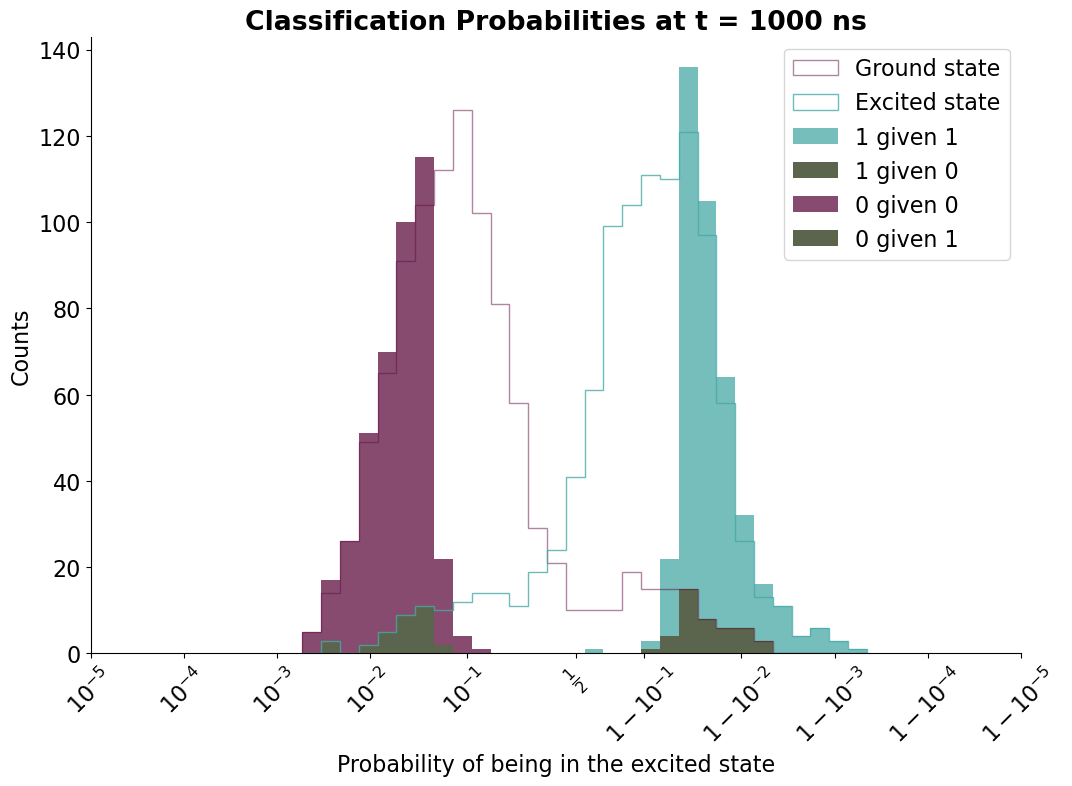

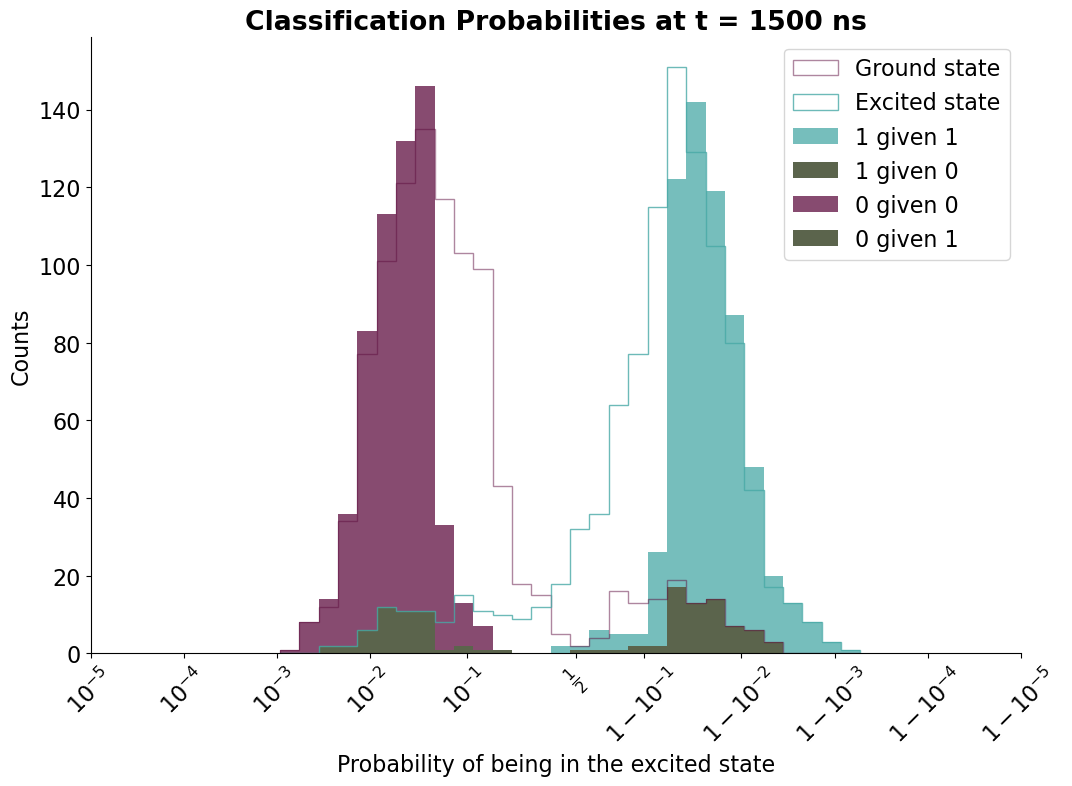

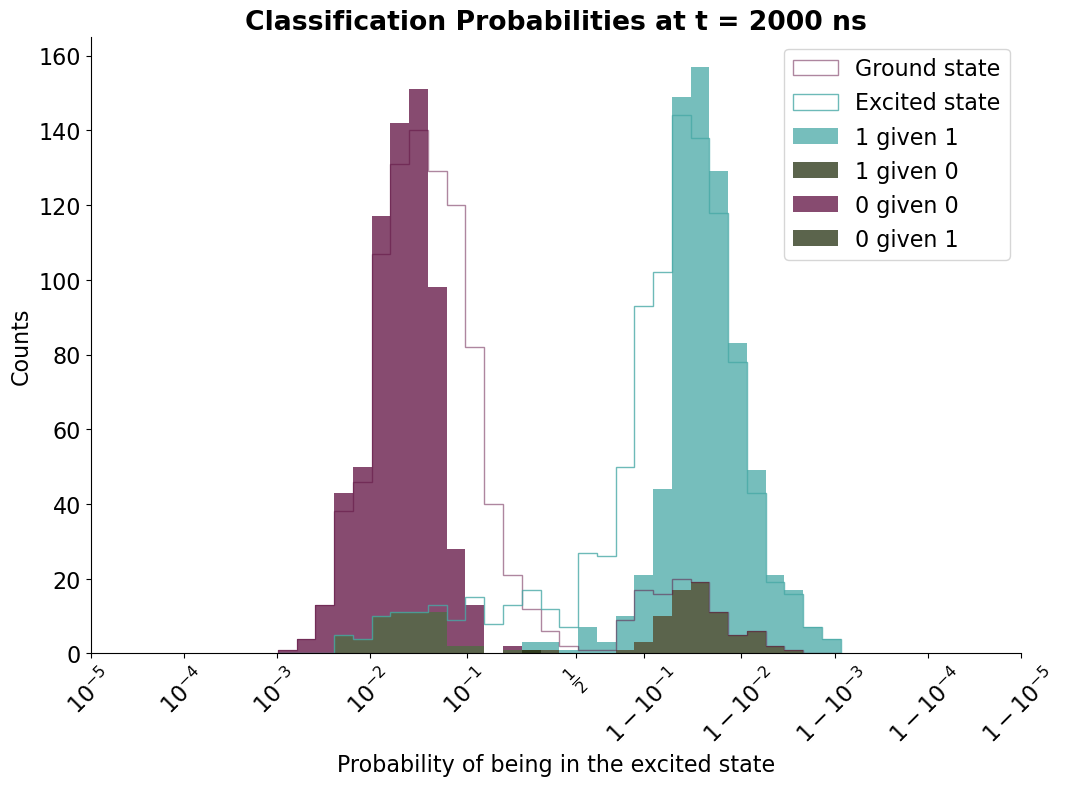

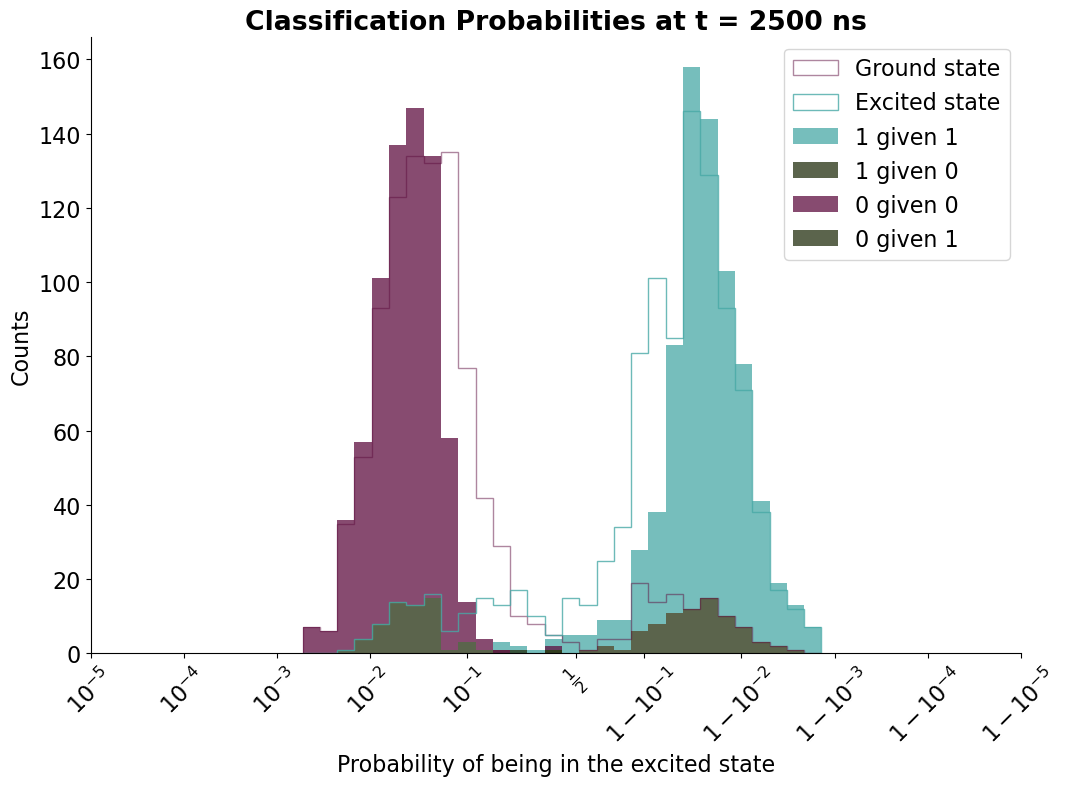

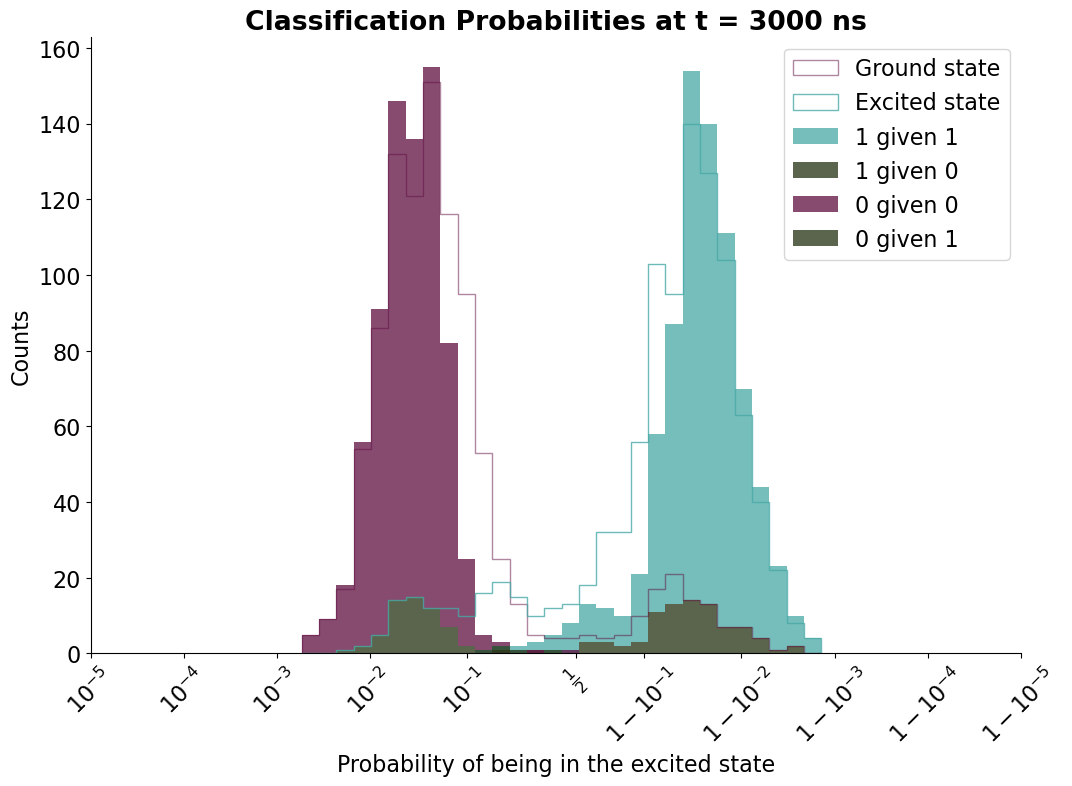

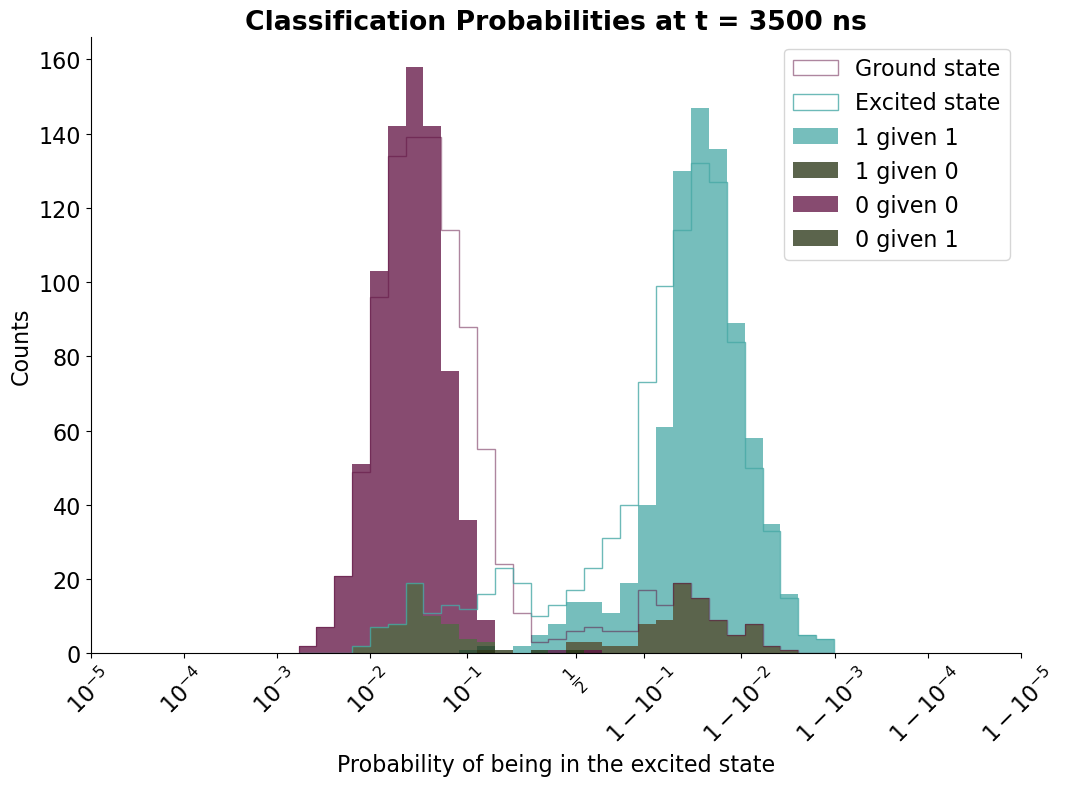

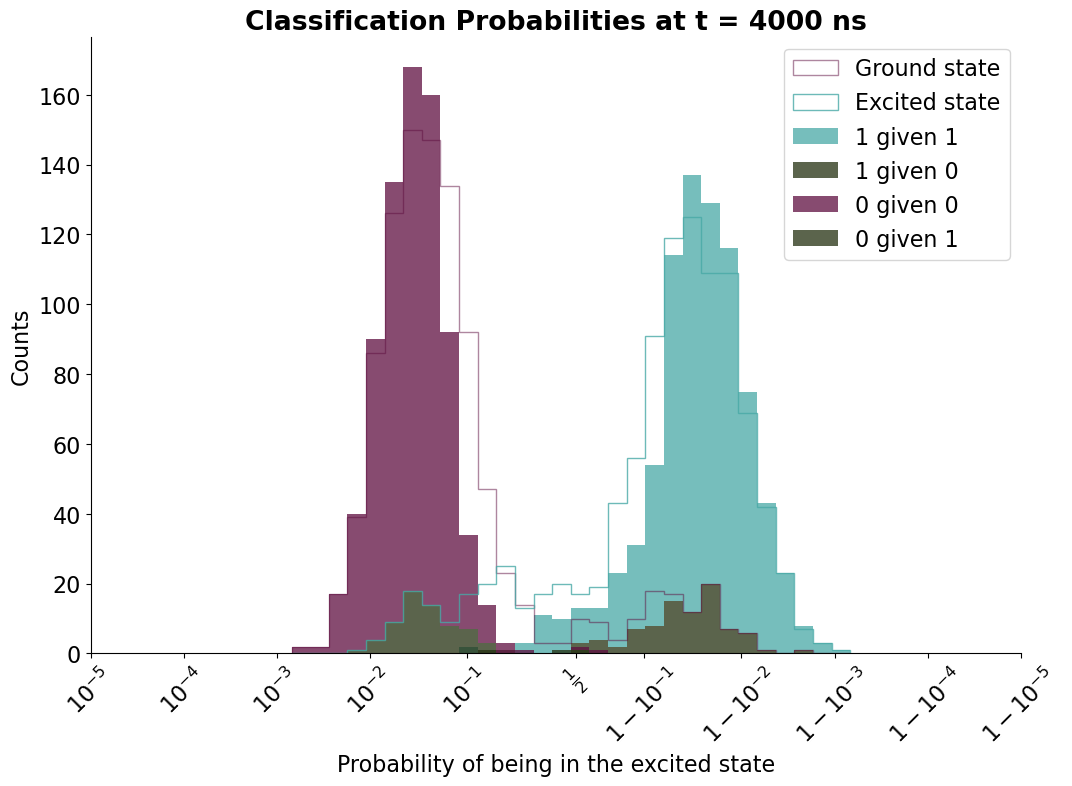

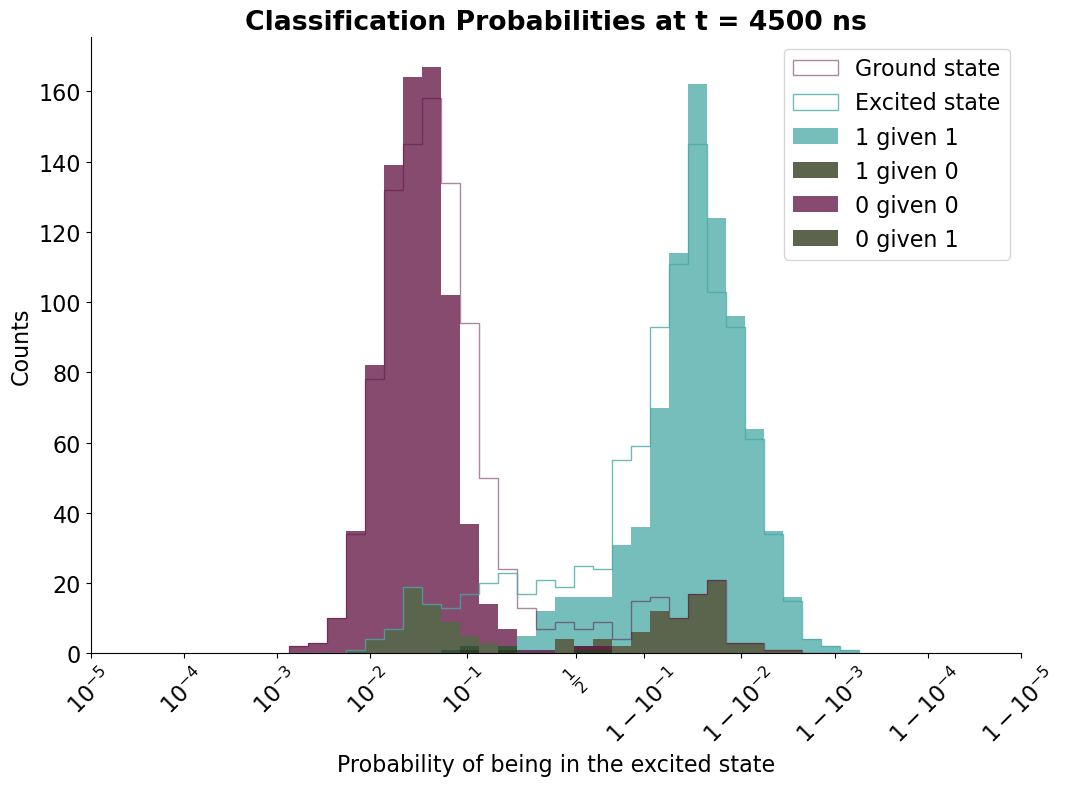

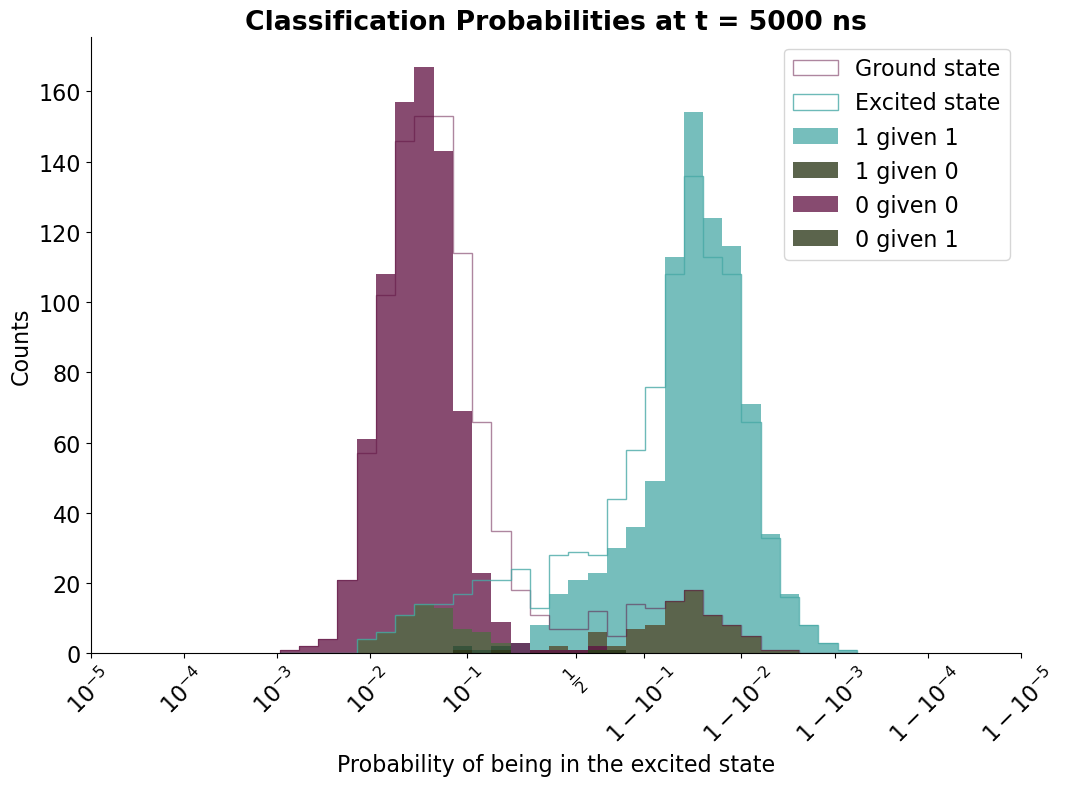

In [32]:
# Repeat above for bigger chuncks of data

classification = np.full_like(initial_state_train, -1)
threshold = 0.95

for interval_end in np.arange(500, 5500, 500):

    fig, ax = plt.subplots(1, 1)

    probs = mf_model(IQ_train, initial_state_train, interval = (0, interval_end))


    certain = probs > threshold
    decide = np.logical_and(classification == -1, certain.sum(axis = 1) > 0)
    classification[decide] = certain[decide].argmax(axis = 1)

    bins = np.linspace(min(logit(probs[:, 1])), max(logit(probs[:, 1])), 31)

    logit_1_given_0 = logit(probs[initial_state_train == 0, 1])
    classified_1_given_0 = logit_1_given_0[classification[initial_state_train == 0] == 1]
    classified_0_given_0 = logit_1_given_0[classification[initial_state_train == 0] == 0]
    logit_1_given_1 = logit(probs[initial_state_train == 1, 1])
    classified_1_given_1 = logit_1_given_1[classification[initial_state_train == 1] == 1]
    classified_0_given_1 = logit_1_given_1[classification[initial_state_train == 1] == 0]

    keep = np.sum(certain, axis = 1)

    # True distributions
    ax.hist(logit_1_given_0,        bins = bins, stacked = True, alpha = 0.5, label = "Ground state", histtype = "step", linewidth = 1, color = "C0");
    ax.hist(logit_1_given_1,       bins = bins, stacked = True, alpha = 0.8, label = "Excited state",   histtype = "step", linewidth = 1, color = "C1")
    
    ax.hist([classified_1_given_0, classified_1_given_1],   bins = bins, stacked = True, 
            alpha = 0.75, label = ["1 given 0", "1 given 1"], histtype = "stepfilled", 
            linewidth = 5, color = ["C2", "C1"]);
    ax.hist([classified_0_given_1, classified_0_given_0],  bins = bins, stacked = True,
            alpha = 0.75, label = ["0 given 1", "0 given 0"], histtype = "stepfilled",
            linewidth = 5, color = ["C2", "C0"]);
    
    # ax.hist(classified_0_given_0,   bins = bins, stacked = True, alpha = 0.75, label = "Correct 0 given 0", histtype = "step", linewidth = 5, color = "C0");

    # ax.hist(classified_0_given_1,  bins = bins, stacked = True, alpha = 0.8, label = "Wrong 0 given 1", histtype = "stepfilled", color = "C1", hatch = r"///", edgecolor = "C0");
    # ax.hist(classified_1_given_0,  bins = bins, stacked = True, alpha = 0.8, label = "Wrong 1 given 0", histtype = "stepfilled", color = "C0", hatch = r"\\\\", edgecolor = "C1");


    label_pos = np.concatenate([logit(10. ** np.arange(-5, 0)), [0.5],  logit(1 - 10. ** np.arange(-5, 0))])
    labels_left =  [f"$10^{{{number}}}$" for number in np.arange(-5, 0)]
    labels_mid  = [r"$\frac{1}{2}$"]
    labels_right = [f"$1 - 10^{{{number}}}$" for number in np.arange(-5, 0)]

    ax.set_xticks(label_pos)
    ax.set_xticklabels(labels_left + labels_mid + labels_right, rotation = 45)

    ax.set(
        xlabel = "Probability of being in the excited state",
        ylabel = "Counts",
        title  = f"Classification Probabilities at t = {interval_end} ns"
    )
    
    ax.legend()

# Decide the rest
forced_decision = classification == -1
classification[forced_decision] = probs[forced_decision].argmax(axis = 1) 


from sklearn.metrics import accuracy_score
accuracy_score(initial_state_train, classification), accuracy_score(initial_state_train[forced_decision], classification[forced_decision]), accuracy_score(initial_state_train[~forced_decision], classification[~forced_decision])


In [33]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def get_accuracy(threshold, end_time):
    classification = np.full_like(initial_state_train, -1)
    
    for interval_end in np.arange(100, end_time, 100):        
        probs = mf_model(IQ_train, initial_state_train, interval=(0, interval_end))

        certain = probs > threshold
        decide = np.logical_and(classification == -1, certain.sum(axis=1) > 0)
        classification[decide] = certain[decide].argmax(axis=1)

    # Decide the rest
    forced_decision = classification == -1
    classification[forced_decision] = probs[forced_decision].argmax(axis=1) 
        
    return accuracy_score(initial_state_train, classification), accuracy_score(initial_state_train[forced_decision], classification[forced_decision]), accuracy_score(initial_state_train[~forced_decision], classification[~forced_decision])


thresholds = np.linspace(0.75, 1.00, 40)
end_times  = np.arange(500, 5100, 100)

accuracies = np.zeros((len(thresholds), len(end_times)))
non_forced_accuracies = np.zeros((len(thresholds), len(end_times)))


for i in tqdm(range(len(thresholds))):
    for j in range(len(end_times)):
        accuracies[i, j] = get_accuracy(thresholds[i], end_times[j])[0]
        non_forced_accuracies[i, j] = get_accuracy(thresholds[i], end_times[j])[2]

 82%|████████▎ | 33/40 [13:16<02:46, 23.77s/it]/home/johannseverin/anaconda3/envs/qi/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/johannseverin/anaconda3/envs/qi/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/johannseverin/anaconda3/envs/qi/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/johannseverin/anaconda3/envs/qi/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 85%|████████▌ | 34/40 [13:40<02:23, 23.88s/it]/home/johannseverin/anaconda3/envs/qi/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/johannseverin/anaconda3/envs/qi/lib/python3.9/site

/tmp/ipykernel_3083/810762456.py:6: UserWarning: No contour levels were found within the data range.
  ax.contour(accuracies, levels = [0.95], colors = "k", alpha = 0.5, extent = [end_times[0]/1000, end_times[-1]/1000, thresholds[0], thresholds[-1]], linewidths = 2)


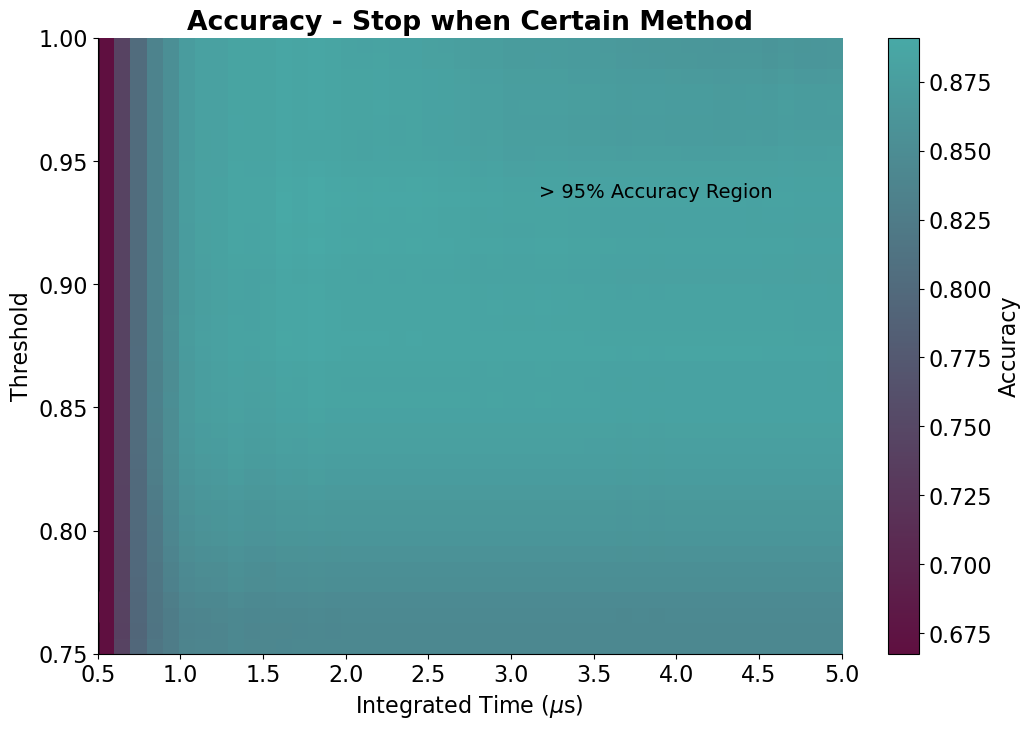

In [34]:
fig, ax = plt.subplots()
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("mycmap", ["C0", "C1"])
image = ax.imshow(accuracies, aspect = "auto", origin = "lower", extent = [end_times[0]/1000, end_times[-1]/1000, thresholds[0], thresholds[-1]], cmap = cmap)

ax.contour(accuracies, levels = [0.95], colors = "k", alpha = 0.5, extent = [end_times[0]/1000, end_times[-1]/1000, thresholds[0], thresholds[-1]], linewidths = 2)
ax.text(0.75, 0.75, "> 95% Accuracy Region", ha = "center", va = "center", transform = ax.transAxes, color = "k", fontsize = 14)


ax.set(
    xlabel = r"Integrated Time ($\mu$s)",
    ylabel = "Threshold",
    title  = "Accuracy - Stop when Certain Method"
)

cbar = fig.colorbar(image, ax = ax)
cbar.set_label("Accuracy")


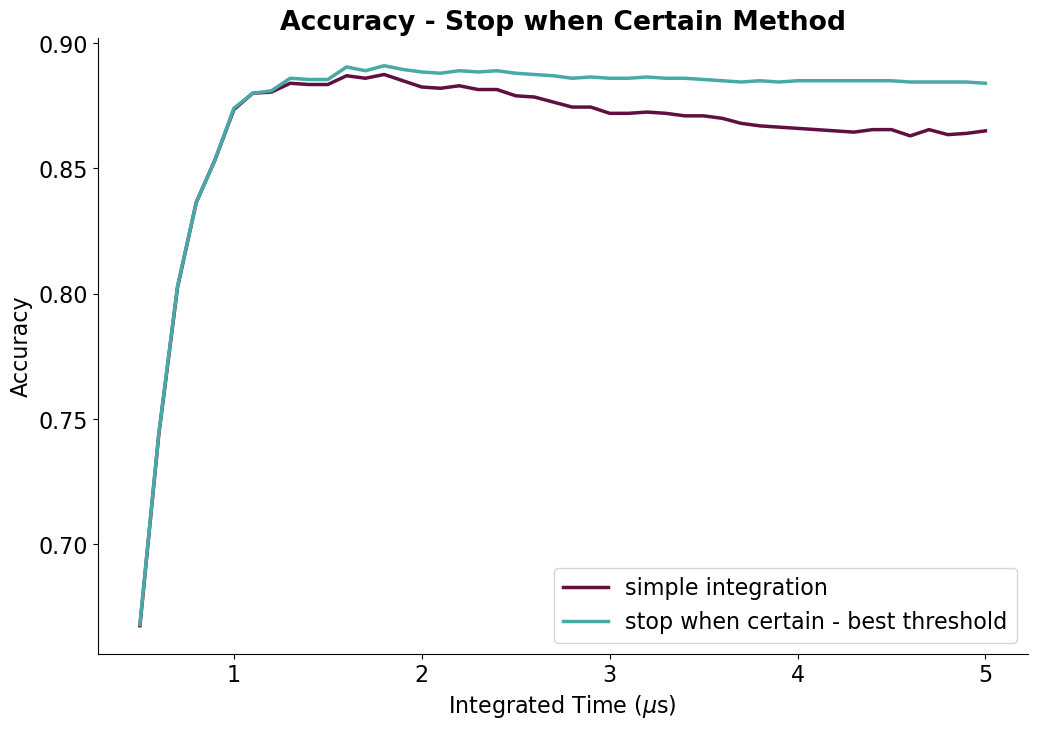

In [35]:
fig, ax = plt.subplots()

ax.plot(end_times/1000, accuracies[-1, :], label = "simple integration")
ax.plot(end_times/1000, accuracies.max(axis = 0), label = "stop when certain - best threshold")

ax.set(
    xlabel = r"Integrated Time ($\mu$s)",
    ylabel = "Accuracy",
    title  = "Accuracy - Stop when Certain Method"
)

ax.legend()

[Text(0.5, 0, 'Threshold'),
 Text(0, 0.5, 'Accuracy'),
 Text(0.5, 1.0, 'Accuracy - Stop when Certain Method')]

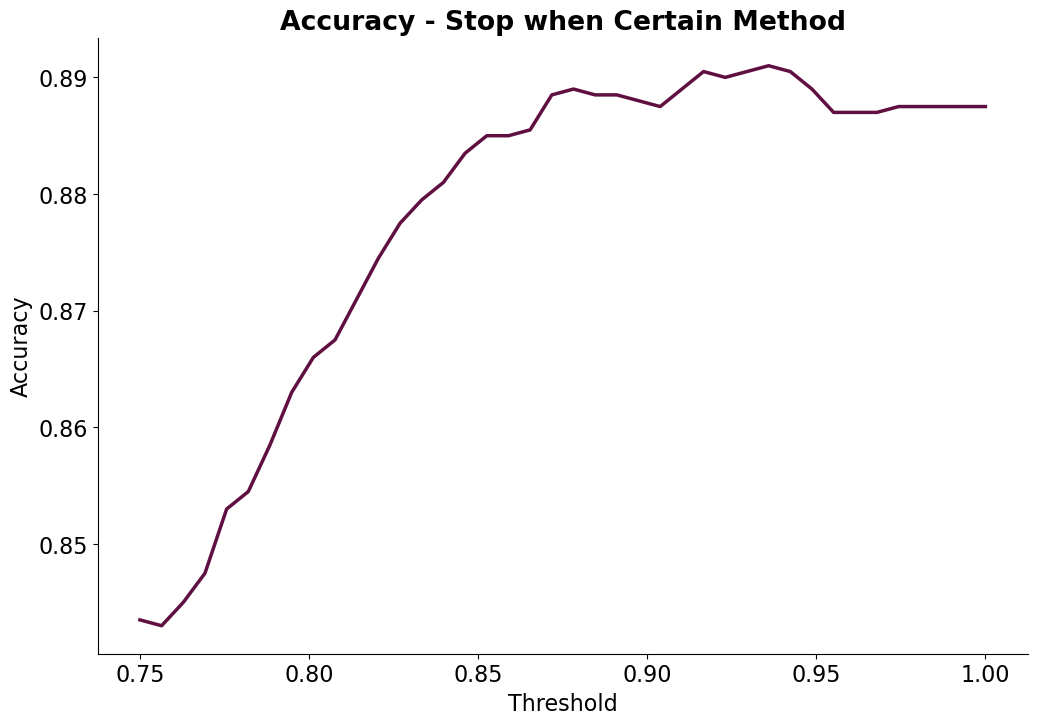

In [36]:
fig, ax = plt.subplots()

# ax.plot(thresholds, accuracies[-1, :], label = "simple integration")
ax.plot(thresholds, accuracies.max(axis = 1), label = "stop when certain - best duration")

ax.set(
    xlabel = r"Threshold",
    ylabel = "Accuracy",
    title  = "Accuracy - Stop when Certain Method"
)